In [1]:
import numpy as np

In [2]:
import os

In [3]:
from updown_data import updown_z

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta


Using TensorFlow backend.


In [6]:
import pandas as pd

In [7]:
from get_iterations import get_n_iterations, get_class_weights

In [8]:
from multi_files_generator import Xy_gen_TZ as generator_tz

In [9]:
train_test_dir = os.path.join("train_test_files", "cosz")

fnames_train = np.asarray([os.path.join(train_test_dir, "Xy_train{}_sel5_doms.npz".format(i+1)) for i in range(100)])
fnames_test = np.asarray([os.path.join(train_test_dir, "Xy_test{}_sel5_doms.npz".format(i+1)) for i in range(100)])
fnames_validation = np.asarray([os.path.join(train_test_dir, "Xy_val{}_sel5_doms.npz".format(i+1)) for i in range(100)])

#fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_updown.npz"for i in range(100)])

In [10]:
n_files = 100
steps_per_epoch, n_events = get_n_iterations(fnames_train[:n_files])
print(steps_per_epoch, n_events)
validation_steps, n_evts_val = get_n_iterations(fnames_validation[:n_files])
print(validation_steps, n_evts_val)

prediction_steps, n_evts_test = get_n_iterations(fnames_test[:n_files])
print(prediction_steps, n_evts_test)

get_class_weights(fnames_train[:n_files])
cls_weights = {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))}


(2588, 165610)
(648, 41451)
(810, 51818)


In [13]:
def vgg_tz(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False, pooling_size=(2, 2)):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, pooling_size=(6, 6))#, include_dense)
        
    x = Dense(512, activation='relu', name='fc-1')(zt_branch)
    x = Dense(512, activation='relu', name='fc-2')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=zt_layer, outputs=predictions, name='vgglike_tz')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

### testing updown with cosz (cosz<=0: down, cosz>0: up)

In [14]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_tz_net = vgg_tz(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           'class_weight' : {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))},
           "callbacks": [#TensorBoard(batch_size=b_size, histogram_freq=5, embeddings_freq=5,
                         #           embeddings_layer_names=["zt_block1_conv1", "zt_block1_conv2"]), 
                         ModelCheckpoint("models/vgg_tz_updown_cosz_cls_weighted_"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5",
                                                        save_best_only=True),
                         EarlyStopping(monitor="val_loss", patience=5)]}
history_vgg_tz = vgg_tz_net.fit_generator(generator_tz(fnames_train[:n_files], batch_size=b_size), 
                                          validation_data=generator_tz(fnames_validation[:n_files]),
                                          validation_steps=validation_steps, **fitargs)




Epoch 1/100
2588/2588 [==============================] - 448s - loss: 0.2360 - acc: 0.8951 - val_loss: 0.1637 - val_acc: 0.9279
Epoch 2/100
2588/2588 [==============================] - 431s - loss: 0.1699 - acc: 0.9284 - val_loss: 0.1577 - val_acc: 0.9297
Epoch 3/100
2588/2588 [==============================] - 434s - loss: 0.1611 - acc: 0.9324 - val_loss: 0.1543 - val_acc: 0.9308
Epoch 4/100
2588/2588 [==============================] - 428s - loss: 0.1558 - acc: 0.9345 - val_loss: 0.1526 - val_acc: 0.9317
Epoch 5/100
2588/2588 [==============================] - 431s - loss: 0.1519 - acc: 0.9364 - val_loss: 0.1529 - val_acc: 0.9318
Epoch 6/100
2588/2588 [==============================] - 432s - loss: 0.1486 - acc: 0.9377 - val_loss: 0.1526 - val_acc: 0.9323
Epoch 7/100
2588/2588 [==============================] - 432s - loss: 0.1458 - acc: 0.9391 - val_loss: 0.1521 - val_acc: 0.9327
Epoch 8/100
2588/2588 [==============================] - 431s - loss: 0.1430 - acc: 0.9406 - val_loss: 0

In [11]:
import keras

In [12]:
vgg_tz_net = keras.models.load_model("models/vgg_tz_updown_cosz_cls_weighted_100files_64_12x12_100epochs.hdf5")

### prediction

In [13]:
from multi_files_generator import generate_metadata

In [14]:
dir_xy = "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/"
dir_train_test = "train_test_files/cosz/"
index_filelist = [os.path.join(dir_train_test, "Xy_indx{}_sel5_doms.npz".format(i+1)) for i in range(100)]
xy_filelist = [(os.path.join(dir_xy, "Xy_numu_{}_multi_data.npz".format(i+1)), 
                os.path.join(dir_xy, "Xy_nue_{}_multi_data.npz".format(i+1))) for i in range(100)]
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx", "posy", "posz", "dist"]


In [15]:
y_true = list()
y_pred = list()
Y_probs = None
metadata = None
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], batch_size=64)
print(predict_steps, n_test_events)

metadata_gen  = generate_metadata(index_filelist, xy_filelist, metadata_keylist)
data_gen = generator_tz(fnames_test[:n_files], batch_size=64)

for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    Y_batch_pred = vgg_tz_net.predict_on_batch(ZT_batch)
    if Y_probs is None:
        Y_probs = Y_batch_pred
    else:
        Y_probs = np.vstack((Y_probs, Y_batch_pred))
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)  # required because Y_batch is categorical
    np.argwhere(y_batch_pred!=y_batch_true)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))


(810, 51818)


In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.933903276854


In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
confusion_matrix(y_true, y_pred)

array([[22094,  1602],
       [ 1823, 26299]])

In [17]:
confusion_matrix(y_true, y_pred)

array([[21963,  1733],
       [ 1694, 26428]])

In [18]:
Y_probs.shape

(51818, 2)

In [19]:
metadata

,E,dirx,diry,dirz,posx,posy,posz,dist,file_evt_index,evt_index
0,7.363040e+02,-0.827540,0.396100,0.397850,-272.307,-4.084,-158.369,270.957155,0,1608
1,2.120990e+03,0.197537,-0.333124,-0.921959,-156.908,46.530,209.152,115.123164,0,173
2,1.203270e+04,-0.504102,-0.812768,0.292043,667.434,230.793,114.812,520.883049,0,463
3,4.933900e+04,-0.174727,0.916099,0.360880,-2.678,55.944,37.402,16.814229,0,2353
4,6.110150e+03,0.851402,-0.317798,0.417277,-330.826,276.509,-343.280,201.986057,0,2129
5,1.038740e+04,0.772722,0.486062,-0.408222,-6.944,205.169,331.969,388.139268,0,1966
6,1.906520e+02,-0.333934,-0.742683,0.580439,-372.718,-140.365,23.792,316.814125,0,1583
7,1.942250e+03,-0.268279,-0.205900,0.941080,259.641,477.066,-167.664,465.892804,0,1963
8,2.120080e+03,-0.852656,-0.522089,-0.020023,380.565,-103.219,-201.567,353.632526,0,259
9,5.926120e+03,0.771974,-0.539742,-0.335760,-610.447,2.364,508.467,466.285120,0,445


In [64]:
import matplotlib.pyplot as plt

In [21]:
mismatches = np.argwhere(y_pred!=y_true).ravel()

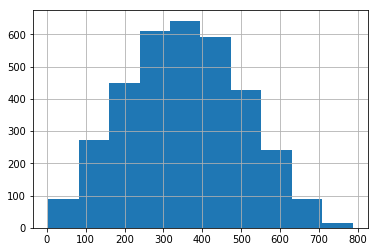

In [22]:
metadata.iloc[mismatches]["dist"].hist()

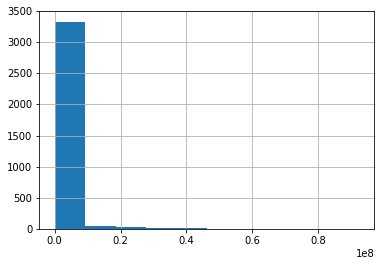

In [23]:
metadata.iloc[mismatches]["E"].hist()

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import to_categorical

In [25]:
n_classes = 2
fpr = dict()
tpr=dict()
roc_auc=dict()
Y_true = to_categorical(y_true)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true[:,i], Y_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

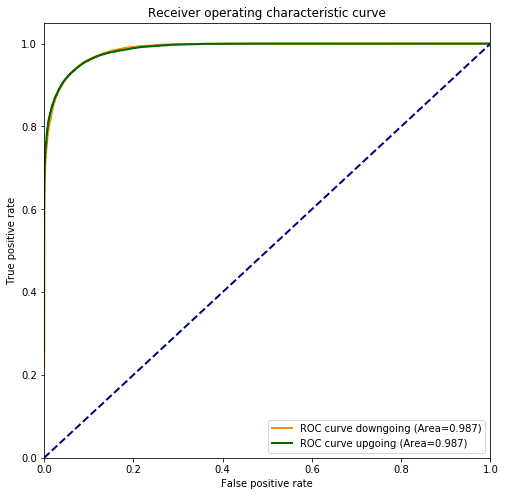

In [26]:
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr[0], tpr[0], color="darkorange",
         lw=lw, label="ROC curve downgoing (Area=%0.3f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], color="darkgreen",
         lw=lw, label="ROC curve upgoing (Area=%0.3f)" % roc_auc[1])

plt.plot([0,1],[0,1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()


In [131]:
from sklearn.metrics import recall_score, precision_score, precision_recall_curve

In [136]:
from sklearn.metrics import average_precision_score

In [132]:
precision_score(y_true, y_pred)

0.9384609921522673

In [133]:
recall_score(y_true, y_pred)

0.9397624635516677

In [138]:
average_precision = average_precision_score(y_true, y_pred)

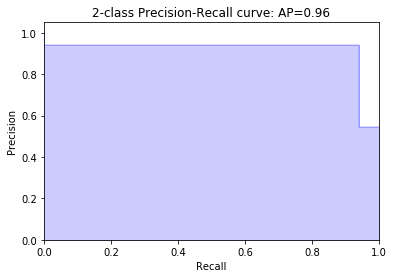

In [141]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.step(recall, precision, color="b", alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title("2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision))

plt.show()

### efficiency plots

In [388]:
match_indices = np.where(y_true==y_pred)[0]

In [389]:
def efficiency(metadata, target_key, match_indices, logscale=False, nbins=12, xlabel=""):
    fig, axis = plt.subplots()
        
    metadata_arr = metadata[target_key]
    well_classified_evts_metadata = metadata.iloc[match_indices][target_key]
    
    if logscale:
        metadata_arr = np.log10(metadata_arr)
        well_classified_evts_metadata = np.log10(well_classified_evts_metadata)
        
    r_min, r_max = (metadata_arr.min(), metadata_arr.max())
    binned_var, bins_to_plot = np.histogram(metadata_arr, bins=nbins, 
                                             range = (r_min, r_max))
    binned_well_cls, _ = np.histogram(well_classified_evts_metadata, bins = nbins, 
                                     range= (r_min, r_max))
    efficiency = np.true_divide(binned_well_cls, binned_var)
    
    axis.plot(bins_to_plot[:-1], efficiency)
    axis.grid()
    axis.set_xlabel(xlabel)
    axis.set_ylabel("well_classified / total test events", size=12)
    axis.set_xlim([r_min, r_max])
    axis.set_ylim([0.0, 1.0])
    axis.set_title("Classification efficiency")
    

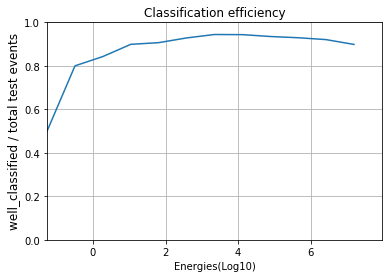

In [390]:
efficiency(metadata, "E", match_indices, logscale=True, xlabel="Energies(Log10)")

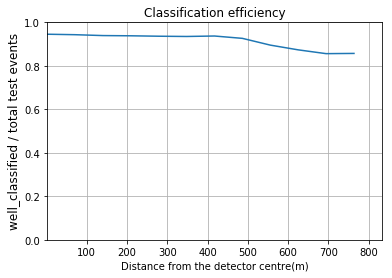

In [372]:
efficiency(metadata, "dist", match_indices, logscale=False, xlabel="Distance from the detector centre(m)")

In [171]:
def energy_maps(energies, nbins = 5):
    
    log_energies = np.log10(energies)
    
    E_maps = []
    binned, energy_bins = np.histogram(log_energies,bins=nbins)#, 
                                  #range=(log_energies.min(), log_energies.max()))

    for i, E in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
        lowE, highE = E
        E_maps.append((i, np.where(np.logical_and(log_energies>=lowE, log_energies<highE))[0]))
    return E_maps

In [173]:
E_maps = energy_maps(energies)

In [291]:
def distance_maps(distances, nbins = 5):
    
    d_maps = []
    binned, dist_bins = np.histogram(distances,bins=nbins)#, 
                                  #range=(log_energies.min(), log_energies.max()))
    for i, d in enumerate(zip(dist_bins[:-1],dist_bins[1:])):
        lowd, highd = d
        d_maps.append((i, np.where(np.logical_and(distances>=lowd, distances<highd))[0]))
    return d_maps

In [292]:
d_maps = distance_maps(metadata["dist"])

### ROC function

In [353]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import to_categorical


def roc_function(E_map_list, y_true, y_pred, Y_probs, var, y_n_classes = 2):
    Y_true = to_categorical(y_true)
    n_classes = 2
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(10, 7))
    plt.grid()
    color_list = ["red", "blue", "green", "orange", "magenta", "brown", "black"]
    
    for em in range(len(E_map_list)):
        E_map = E_map_list[em][1]
    
        for i, ls in zip(range(n_classes), ['--', '-']):
            fpr[i], tpr[i], _ = roc_curve(Y_true[E_map][:,i], Y_probs[E_map][:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            lw = 1.5
            
            plt.plot(fpr[i], tpr[i], color=color_list[em], linestyle=ls,
                     lw=lw, label="ROC curve {} slice {} class {} (Area={:.3f})".format(var, em+1, i, roc_auc[i]))
            
            plt.plot([0,1],[0,1], color="navy", lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.01])
            plt.xlabel("False positive rate", size=12)
            plt.ylabel("True positive rate", size=12)
            plt.title("Receiver operating characteristic curve")
            plt.legend(loc="lower right")
            
        
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true[E_map], y_pred[E_map])
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        
    

        
    return


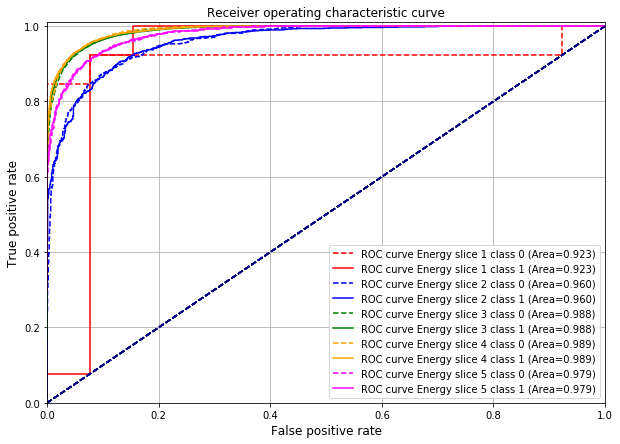

In [354]:
roc_function(E_maps, y_true, y_pred, Y_probs, "Energy" )

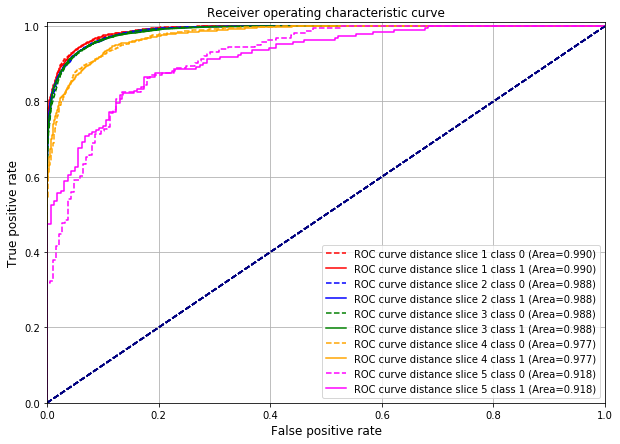

In [355]:
roc_function(d_maps, y_true, y_pred, Y_probs, "distance" )

### multi slice efficiency plots to be done

In [ ]:
def efficiency(metadata, target_key, match_indices, logscale=False, nbins=12, xlabel=""):
    fig, axis = plt.subplots()
        
    metadata_arr = metadata[target_key]
    well_classified_evts_metadata = metadata.iloc[match_indices][target_key]
    
    if logscale:
        metadata_arr = np.log10(metadata_arr)
        well_classified_evts_metadata = np.log10(well_classified_evts_metadata)
        
    r_min, r_max = (metadata_arr.min(), metadata_arr.max())
    binned_var, bins_to_plot = np.histogram(metadata_arr, bins=nbins, 
                                             range = (r_min, r_max))
    binned_well_cls, _ = np.histogram(well_classified_evts_metadata, bins = nbins, 
                                     range= (r_min, r_max))
    efficiency = np.true_divide(binned_well_cls, binned_var)
    
    axis.plot(bins_to_plot[:-1], efficiency)
    axis.grid()
    axis.set_xlabel(xlabel)
    axis.set_ylabel("well_classified / total test events", size=12)
    axis.set_xlim([r_min, r_max])
    axis.set_ylim([0.0, 1.0])
    axis.set_title("Classification efficiency")
    